<a href="https://colab.research.google.com/github/shu65/diffusion-model-book/blob/main/diffusion_model_book_2_2_score_based_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tqdm import tqdm_notebook as tqdm
import torch

device="cpu"

In [2]:
n_samples = int(1e6)
sigma = 0.01

dist0 = torch.distributions.MultivariateNormal(torch.tensor([-2, -2], dtype=torch.float).to(device), sigma*torch.eye(2, dtype=torch.float).to(device))
samples0 = dist0.sample(torch.Size([n_samples//2]))
    
dist1 = torch.distributions.MultivariateNormal(torch.tensor([2, 2], dtype=torch.float).to(device), sigma*torch.eye(2, dtype=torch.float).to(device))
samples1 = dist1.sample(torch.Size([n_samples//2]))
samples = torch.vstack((samples0, samples1))

mean = torch.mean(samples, dim=0)
std = torch.std(samples, dim=0)

normalized_samples = (samples - mean[None, :])/std[None, :]

dataset = torch.utils.data.TensorDataset((normalized_samples))

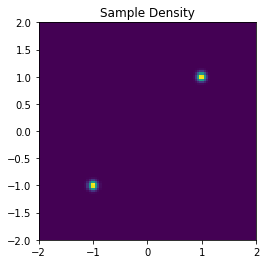

In [3]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

plot_samples = normalized_samples.cpu().numpy()

plt.hist2d(plot_samples[:,0], plot_samples[:,1], range=((-2, 2), (-2, 2)), cmap='viridis', rasterized=False, bins=100, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.title('Sample Density')
plt.show()

In [4]:
sigma_begin = 0.001
sigma_end = 1.0
T = 200
sigmas = torch.tensor(np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), T))).float().to(device)

In [5]:
def dsm_loss(score_model, samples, sigmas):
  t = torch.randint(0, len(sigmas), (samples.shape[0],), device=sigmas.device)
  used_sigmas = sigmas[t].view(samples.shape[0], *([1] * len(samples.shape[1:])))
  noise = torch.randn_like(samples) * used_sigmas
  perturbed_samples = samples + noise
  target = - 1 / (used_sigmas ** 2) * noise
  scores = score_model(perturbed_samples, used_sigmas)
  target = target.view(target.shape[0], -1)
  scores = scores.view(scores.shape[0], -1)
  w = used_sigmas.squeeze(-1) ** 2
  loss = ((scores - target) ** 2).sum(dim=-1) * w
  return loss.mean()

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScoreModel(nn.Module):
  def __init__(self, n_channels=2):
    super(ScoreModel, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(n_channels, 2*n_channels),
        nn.ELU(),
        nn.Linear(2*n_channels, 16*n_channels),
        nn.ELU(),
        nn.Linear(16*n_channels, 2*n_channels),
        nn.ELU(),
        nn.Linear(2*n_channels, n_channels),
    )

  def forward(self, x, sigma):
    y = self.model(x)
    return y/sigma

In [7]:
import torch

batch_size = 512
n_steps = 100000

dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True, num_workers=0)
dataloader_iter = iter(dataloader)

score_model = ScoreModel().to(device)

optimizer = torch.optim.Adam(score_model.parameters())
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=n_steps)



for i in range(n_steps):
  try:
    x = next(dataloader_iter)[0]
  except StopIteration:
    dataloader_iter = iter(dataloader)
    x = next(dataloader_iter)[0]
  x = x.to(device)

  optimizer.zero_grad()
  loss = dsm_loss(score_model, x, sigmas)
  loss.backward()
  optimizer.step()
  lr_scheduler.step()
  if (i % 1000) == 0:
    print(f"{i} steps loss:{loss}")


0 steps loss:2.062662363052368
1000 steps loss:1.9592573642730713
2000 steps loss:1.7652524709701538
3000 steps loss:1.6643431186676025
4000 steps loss:1.6651298999786377
5000 steps loss:1.811767578125
6000 steps loss:1.7746050357818604
7000 steps loss:1.7219853401184082
8000 steps loss:1.6121973991394043
9000 steps loss:1.5658706426620483
10000 steps loss:1.5082696676254272
11000 steps loss:1.6191147565841675
12000 steps loss:1.369584083557129
13000 steps loss:1.5210020542144775
14000 steps loss:1.3806142807006836
15000 steps loss:1.5240064859390259
16000 steps loss:1.2849103212356567
17000 steps loss:1.3859660625457764
18000 steps loss:1.386408805847168
19000 steps loss:1.4118430614471436
20000 steps loss:1.270074725151062
21000 steps loss:1.1704328060150146
22000 steps loss:1.2353748083114624
23000 steps loss:1.4386141300201416
24000 steps loss:1.1812832355499268
25000 steps loss:1.4304351806640625
26000 steps loss:1.3862476348876953
27000 steps loss:1.4564437866210938
28000 steps l

In [8]:
def sbm_sample(n_samples, score_model, sigmas, alpha=0.1):
    sigma_T = sigmas[-1]
    x_0 = torch.randn(n_samples, 2)*sigma_T
    x_tk = x_0
    K = 200
    for t in range(len(sigmas) -1, -1, -1):
      sigma_t = sigmas[t]
      alpha_t = alpha*(sigma_t**2)/(sigma_T**2)
      print(f"t:{t}, sigma_t:{sigma_t}, alpha_t:{alpha_t}")
      for k in range(K+1):
        u_k = torch.randn(n_samples, 2)
        if (k == K) and t == 0:
          u_k[:, :] = 0.0
        with torch.no_grad():
          score = score_model(x_tk, sigma_t)
          x_tk = x_tk + alpha_t * score + np.sqrt(2 * alpha_t) * u_k
    return x_tk

In [9]:
samples_pred = sbm_sample(n_samples=100000, score_model=score_model, sigmas=sigmas)
samples_pred = samples_pred.cpu().numpy()

t:199, sigma_t:1.0, alpha_t:0.10000000149011612
t:198, sigma_t:0.965883195400238, alpha_t:0.09329303354024887
t:197, sigma_t:0.9329304099082947, alpha_t:0.08703591674566269
t:196, sigma_t:0.90110182762146, alpha_t:0.08119844645261765
t:195, sigma_t:0.8703591227531433, alpha_t:0.07575250416994095
t:194, sigma_t:0.8406652808189392, alpha_t:0.07067181169986725
t:193, sigma_t:0.8119844794273376, alpha_t:0.06593187898397446
t:192, sigma_t:0.7842822074890137, alpha_t:0.061509858816862106
t:191, sigma_t:0.7575250267982483, alpha_t:0.057384420186281204
t:190, sigma_t:0.731680691242218, alpha_t:0.053535666316747665
t:189, sigma_t:0.7067181468009949, alpha_t:0.049945052713155746
t:188, sigma_t:0.6826071739196777, alpha_t:0.0465952567756176
t:187, sigma_t:0.6593188047409058, alpha_t:0.04347012937068939
t:186, sigma_t:0.6368249654769897, alpha_t:0.040554605424404144
t:185, sigma_t:0.6150985956192017, alpha_t:0.03783462941646576
t:184, sigma_t:0.5941134095191956, alpha_t:0.035297077149152756
t:183,

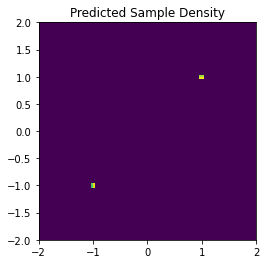

In [10]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

plt.hist2d(samples_pred[:,0], samples_pred[:,1], range=((-2, 2), (-2, 2)), cmap='viridis', rasterized=False, bins=100, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.title('Predicted Sample Density')
plt.show()